In [1]:
%load_ext autoreload
%autoreload 2

from    src import init, posteriors, plots_oop 
import  emcee
import  numpy                   as np 
import  matplotlib.pyplot       as plt
from    math                    import inf
from    pathlib                 import Path
from    src.montecarlo          import log_likelihood, DEFAULT_LIMITS
from    src.prior_factory       import create_log_prior, initialize_walkers
from    src.multiprocessing_MC  import run_mcmc_parallel 

plt.style.use('./configurations/style.mplstyle') #? Custom style, makes plots easier to read

import matplotlib as mpl 
import matplotlib.colors as mcolors
colors_for_cycle = [
    mcolors.to_hex(c) for c in plt.cm.plasma(np.linspace(0, 1, 3))
]
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors_for_cycle)

After importing all the libraries necessary to run this code, proceed by creating your directory.

In [2]:
# Where to find the datafiles and save the outputs
datafiles   = Path("datafiles")
output_dir  = init.create_run_dir("Testing_years/alternative_fiducial_newest_bests_good_old_fj10", use_timestamp = False)
#Testing_years/alternative_fiducial_newest_bests_good_old_fj10

Loading existing directory  : Output_files/Testing_years/alternative_fiducial_newest_bests_good_old_fj10


The `Ludo_utils` offer multiple optional utility functions. The `create_run_dir` is a helper to automatically create your run directory it will add a timestamp to the directory name if `use_timestamp` is set to `True`. The logfile will be created in the run directory and is necessary to track the progress of the training. 

# Define the Model Constants

To understand the model parameters the Monte Carlo (MC) simulation makes the following assumptions:

 ➡ The single GRB photon Spectrum is given by a Broken power law (Eq. (1) [here](https://arxiv.org/abs/1711.03106)):

$$
N_E^{\text{SBPL}} = A E_j^\alpha \left[ \left( \frac{E}{E_j} \right)^{- \alpha n} + \left( \frac{E}{E_j} \right)^{- \beta n} \right]^{-\frac{1}{n}} \tag{A.1}
$$

The peak energy ($E_\text{peak}$) of $E^2N_E$ and the energy scale / energy break $E_j$ are related by:

$$
E_j = E_\text{peak} \epsilon
$$

Where $\epsilon = \left( -\frac{\alpha+2}{\beta+2} \right)^{\frac{1}{(\beta - \alpha)n}}$. $n$ is a smoothing parameter. Changing $\alpha$ and $\beta$ will change the slope of the rise/fall of the $E^2N_E$. As can be see in 

<div align="center"> <img src="images/BPL.jpg" alt="Spectral Slopes" width="30%"> </div>

 ➡ The structure of the jet is fixed with $\theta_c$, and the minimum viewing angle is $\theta_v^{min}$. By default they are $3.4^\circ$ and $10^\circ$ respectively. The jet is assumed to be a cone with a half-opening angle $\theta_c$.

 ➡ The maximum redshift to generate a GRB the default is $z_{\text{max}} = 5$. 

In [3]:
# GRB Jet structure assumptions
params = {
    "alpha"         : -0.67,    # 2/3 from synchrotron
    "beta_s"        : -2.59,    # Average value from GRBs
    "n"             : 2,        # Smoothly broken power law curvature
    "theta_c"       : 3.4,      # Ghirlanda half-angle of jet core (from GW170817)
    "theta_v_max"   : 10,       # Maximum viewing angle of the jet (in degrees)
    "z_model"      : 'fiducial_Hrad_A1.0'    #? Optional, model to use for redshift distribution
}

The photon spectrum can be written as
$$
N(E, \theta_v, t) = N_0(\theta_v, t) f\left( \frac{E}{E_0(\theta_v, t)} \right). \tag{A.2}
$$

Where $f(x)$ is the Broken power law from **Eq. (A.1)**. With the peak energy:

$$
E_0(\theta_v, t) = E_0(\theta_v, t=t_p) P_E\left( \frac{t}{t_p}, \theta_v \right), \tag{A.3}
$$

<div class="alert alert-warning" role="alert">
  <strong>Warning:</strong> In the <a href="https://www.aanda.org/articles/aa/pdf/2022/09/aa43705-22.pdf">original paper</a> the energy scale is directly given by the peak energy. In code, it is properly normalized with the ε factor mentioned previously. This should only change the normalization of our learned distributions. But for completeness, the original notation is used.

</div>

where $ t_p $ denotes the peak time of the pulse and $ P_E $ represents the temporal profile, which depends on the viewing angle $ \theta_v $. Similarly, the normalization of the photon spectrum is written as

$$
N_0(\theta_v, t) = N_{0}(\theta_v, t=t_p) P_N\left( \frac{t}{t_p}, \theta_v \right). \tag{A.4}
$$

Both the the peak energy and photon spectrum have the following temporal profiles:

$$
P_N(t, tp, \theta_v) =
\begin{cases}
\dfrac{t}{tp} & \text{if } t < tp \\
\left( \dfrac{t}{tp} \right)^{-\alpha_n(\theta_v)} & \text{otherwise}
\end{cases}, \quad \quad
P_E(t, tp, \theta_v) =
\begin{cases}
1 & \text{if } t < tp \\
\left( \dfrac{t}{tp} \right)^{-\alpha_e(\theta_v)} & \text{otherwise}
\end{cases}
$$

And the following angular profiles (evaluated at $t=t_p$):

$$

R_{En}(\theta_v) = \frac{E_0(\theta_v)}{E_0(\theta_v=0)} = \frac{E_0(\theta_v)}{\hat{E}_0},

\quad \quad 
R_F(\theta_v) = \frac{N_0(\theta_v)|_{E=E_0(\theta_v)}}{\hat{N_0}|_{E=\hat{E}_0}}
$$

As such 8 functions are **precomputed**:
- $\alpha_E(\theta_v)$ and $\alpha_N(\theta_v)$
- $R_{En}(\theta_v)$ and $R_F(\theta_v)$
- $I_0 = \int_{E_1}^{E_2} xf(x)dx$, $I_1 = \int_{E_1'}^{E_2'} xf(x)dx$, $I_2 = \int_{E_1'}^{E_2'}f(x)dx$ and $I_3 = \int_{E_1''}^{E_2''} xf(x)dx$

Found in the `default_interpolator` dictionaries. Specifically the integrals $I_i$ are precomputed to simplify/speed-up a few calculations from the [original paper](https://www.aanda.org/articles/aa/pdf/2022/09/aa43705-22.pdf). 

In [4]:
default_params, default_interpolator, data_dict = init.initialize_simulation(datafiles, params) #? Catalogue data from fermi GBM

Using redshift model: samples_fiducial_Hrad_A1.0_BNSs_0.dat with 359079 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 325, Trigger years: 17.50, Yearly rate: 18.58 events/year


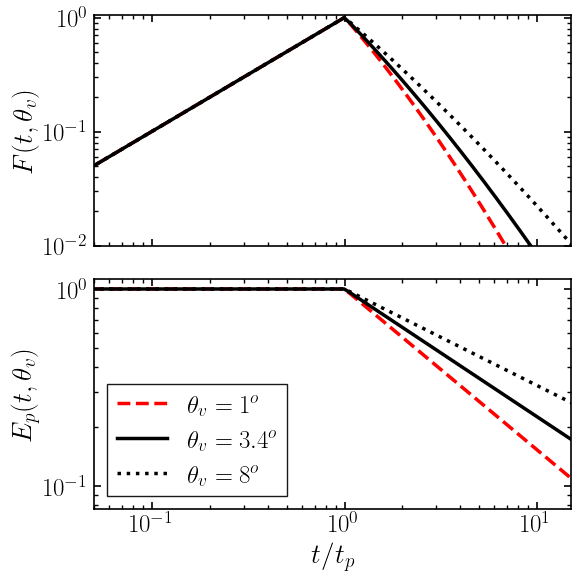

In [10]:
from src.init import get_alpha_n_alpha_e
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
# Load alpha functions (these are functions of viewing angle)
alpha_n_func, alpha_e_func, _, _ = get_alpha_n_alpha_e(Path("datafiles") / 'alpha.txt', Path("datafiles") / 'alpha_e.txt')

def compute_grb_evolution(theta_deg, interps=default_interpolator):
    # Convert to radians
    theta_rad = np.radians(theta_deg)
    
    # Get alpha values for this viewing angle
    alpha_e = alpha_e_func(theta_rad)
    alpha_n = alpha_n_func(theta_rad)
    
    # Define time evolution grid (t/t_peak ratios)
    time_max = 100
    min_ratio, max_ratio = 0.02, 20
    ratio_base = min_ratio * ((max_ratio/min_ratio)**(1.0/(time_max-1)))**np.arange(time_max)
    max_m = np.searchsorted(ratio_base, 1)
    
    # Initialize evolution arrays
    P_e_mat = np.ones(time_max)
    P_n_mat = np.ones(time_max)
    
    # Before peak (t < t_peak, ratio < 1)
    P_n_mat[:max_m] = ratio_base[:max_m]
    
    # After peak (t > t_peak, ratio > 1)
    ratio_after = ratio_base[max_m:]
    P_e_mat[max_m:] = ratio_after**(-alpha_e)
    P_n_mat[max_m:] = ratio_after**(-alpha_n)
    
    # Compute observables
    E_p_obs_base    = 250.0  # keV
    peak_energy     = E_p_obs_base * P_e_mat
    fluence_rate    = P_n_mat * interps.int_4_alt(peak_energy)
    fluence_rate    /= np.max(fluence_rate)  # Normalize to max fluence rate
    return ratio_base, fluence_rate, peak_energy / E_p_obs_base

viewing_angles=[1, 3.4, 8]


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6), sharex=True)
plt.subplots_adjust(hspace=0.05) # Adjust space between plots

# Color and style schemes
colors = ['r', 'k', 'k']
styles = ['--', '-', ':']

for i, theta in enumerate(viewing_angles):
    # Compute evolution for this combination
    time_arr, fluence, peak_energy = compute_grb_evolution(theta)
    
    color = colors[i % len(colors)]
    style = styles[i % len(styles)]
    label = fr"$\theta_v={theta}^o$"
    
    # Plot fluence (top)
    ax1.plot(time_arr, fluence, color=color, linestyle=style, linewidth=2.5)
    
    # Plot peak energy (bottom)
    ax2.plot(time_arr, peak_energy, color=color, linestyle=style, label=label, linewidth=2.5)

# Configure plots
ax1.set_ylabel(r'$F(t, \theta_v)$', fontsize=20)
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlim(0.05, 15)
ax1.set_ylim(1e-2, 1.05)
ax2.set_ylabel(r'$E_p(t, \theta_v)$', fontsize=20)
ax2.set_xlabel(r'$t/t_{p}$', fontsize=20)
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.legend(loc='lower left', fontsize=18)
#xticks size 
ax1.tick_params(axis='x', labelsize=18)
ax1.tick_params(axis='y', labelsize=18)
ax2.tick_params(axis='x', labelsize=18)
ax2.tick_params(axis='y', labelsize=18)
plt.tight_layout()
plt.savefig('grb_evolution.pdf', dpi=500)
plt.show()

## Likelihood

The `emcee` package is used to sample a 7 dimensional parameter space. To be as agnostic as possible flat priors are used. 

#### GRB Prior Parameters

---

<div align="center">

| Parameter | Description | Range | Units |
|-----------|-------------|--------|--------|
| $k$ | Power-law index of spectral function | $[1, 10]$ | - |
| $L_{L0}$ | $Log_{10}$ Isotropic energy scale | $[-2, 1.699]$ | - |
| $L_{\mu E}$ | $Log_{10}$ of mean peak energy | $[2.845, 3.477]$ | keV |
| $\sigma_E$ | Width of peak energy distribution | $[0.05, 1.0]$ | - |
| $L_{\mu \tau}$ | $Log_{10}$ of mean peak time | $[-2, 0.301]$ | s |
| $\sigma_\tau$ | Width of peak time distribution | $[0.05, 1.0]$ | - |
| $f_j$ | $Log_{10}$ of jet beaming fraction | $[-3, 0]$ | - |

</div>

---

**Physical Interpretations:**

➡ To calculate the "scale" of the photon spectrum for $\theta_v = 0$ and $t = t_p$ we need the rest frame on-axis isotropic energy $\hat{E}_{iso}$. The original paper goes into detail on how to calculate it, for simplicity know that the "scale" of $\hat{E}_{iso}$ is controlled by $L_{L0}$ with a distribution that is a cut-off power law of slope $k$. Note that it is adimensional because in the code $L0$ is normalized to $10^{49}$ erg.

➡ $L_{\mu \tau}$: Peak times from 10 ms to 2 s, the 2 s is the cut-off of the catalogue.

➡ $f_j$: Fraction of BNS producing jets from 0.1% to 100%.

#### `emcee` Likelihood

Given how the `emcee` package works the "likelihood" also contains the steps for generating the GRBs from a set of parameters. In other words the way the likelihood is defined is as follows:

1. Extract parameters and check them against the priors.
2. Generate a GRB from the parameters. (the function `log_likelihood` from `montecarlo.py` follows the same structure as the original paper)
3. From the sample of GRBs two sub-samples are created : 
    - **$(t_{90} < 2\text{s}$, $F_p > 0.5 \text{ph/cm}^2/\text{s})$** (FermiGBM cut-off), this is compared to the $\approx 45 $ GRBs/yr detected by Fermi. Giving a poissonian likelihood term: 
    $$p_0 = \text{Poiss}(N_{\text{GRBs}} | \lambda)$$
    - **$(t_{90} < 2\text{s}$, $F_p > 5 \text{ph/cm}^2/\text{s})$**, used to compare the observables from our generated GRBs to the those from the catalogue with the Kolmorogov-Smirnov test:  
    $$p_i = \text{KS}(D_{\text{obs}}^i, D_{\text{gen}}^i)$$
4. Overall the final likelihood is: 
$$
\mathcal{L}(N_{\text{GRBs}}, \vec{D_{\text{obs}}}|\lambda, \vec{D_{\text{gen}}}) = p_0 \prod_i p_i
$$

As the MCMC is running the progress is saved in the `logfile` (.txt) and the `chain` file (.h5). The `chain` file contains the samples of the MCMC, and can be used to restart the MCMC. The `logfile` contains the progress of the MCMC. 

### Creating the prior function

The prior in most cases is defined by flat priors. To quickly generate a function we have a helper function that takes your desired ranges and creates the prior function. For more complicated priors you can define your own prior function.

In [11]:
custom_bounds = {
             'k'        : (1.5, 12),
             'L_L0'     : (-3, 2),
             'L_mu_E'   : (2.5, 4),
             'sigma_E'  : (0, 1),
             'L_mu_tau' : (-2, np.log10(2)), # put a maximum at 2 seconds as the real distribution is with a 2 second mean, this is shifted, so we really don't expect high values
             'sigma_tau': (0, 1.8),
             'f_j'      : (0, 10)
}
my_prior = create_log_prior(custom_bounds)

In [12]:
def log_probability(thetas, default_params=default_params, default_interpolator=default_interpolator):
    # add a bit of noise to the parameters
    lp = my_prior(thetas)	
    
    if not np.isfinite(lp):
        return -inf, 0, 0, 0, 0, 0

    l_out = log_likelihood(thetas, params=default_params, interps=default_interpolator)
    
    if not np.isfinite(l_out[0]):
        return -inf, 0, 0, 0, 0, 0

    return lp + l_out[0], l_out[1], l_out[2], l_out[3], l_out[4], l_out[5]

initial             = np.array([2, -0.51, 3.19, 0.35, -0.1, 0.54, 0.5])
ex_log_likelihood   = log_probability(initial)[0]
print(f"Example log likelihood: {ex_log_likelihood:.2f}")

Example log likelihood: -98.20


## Setting Up an MCMC Sampling with emcee

Running `emcee` is throroughly explained in the (documentation)[https://emcee.readthedocs.io/en/stable/tutorials/line/] for the package. As a quick refresher there are a few parameters that need to be set:

➡ `nW` : The number of walkers in the MCMC. More walkers can explore the parameter space more thoroughly. As a rule of thumb `nW` should be at least twice the number of parameters.

➡ `step` : This is just used to perturb the walkers' initial positions.  

➡ `max_n` : Try different orders of magnitude to see what works best for your problem. The `max_n` is the number of steps the MCMC will take. 

In [13]:
NWALKERS    	= 20
TOTAL_STEPS 	= 300
DISCARD         = 100 # Number of samples to discard for burn-in

pos = initialize_walkers(NWALKERS) # Initializes the walkers within the posterior space, as long as you have (NWALKERS, 7) shape pos works 
print(f"Example walker position: {pos[0]}")

Example walker position: [ 2.81537406 -1.23869599  3.01832743  0.22646903 -0.86627783  0.85538438
  0.62914719]


### Create Output Directory and Filename

In [14]:
filename    = output_dir / "emcee.h5"
backend     = emcee.backends.HDFBackend(filename)

In [15]:
default_params.triggered_years

np.float64(16.6585238286571)

## Running the MCMC

As is standard in `emcee` multiprocessing is used to speed up convergence. The `pool` object is created with the number of cores available. The `sampler` object is created with the `pool` object and the `backend` object. The `sampler` is then run for `max_n` steps. 

In [16]:
sampler = run_mcmc_parallel(
    max_n           =   TOTAL_STEPS,
    backend         =   backend,
    initial_pos     =   pos,      
    log_probability =   log_probability,  
    workers         =   None, #By default None occupies all your CPUs, manually change this if you don't want that 
)       

Resuming from iteration 50000/300
MCMC sampling already completed.


## Plotting the Results / Convergence

We begin by defining the plotting object. 

In [24]:
plotting_ranges = np.array([
    [1.5, 12], [-3, 2], [2, 4], [0.05, 1], [-2, np.log10(2)], [0.05, 1.8], [0, 5]
])

plotter = plots_oop.MCMCPlotter(
        samplers    =   [backend],
        names       =   ['Fiducial Model'],
        output_dir  =   output_dir,
        burn_in     =   DISCARD, 
        thin        =   15,
        ranges      =   plotting_ranges,
)

To avoid re-running the MCMC. Here we could access a pre-run MCMC chain with a different `filename`. However, if you have run the MCMC you can just use the previously defined `backend` object.

In [25]:
#backend = "your backend"

From the `backend` we need to extract `samples`. The initial steps are exploring the likelihood, these are discarded (*burn-in*). The MCMC has multiple walkers, to merge theirs samples use the `flat` flag.

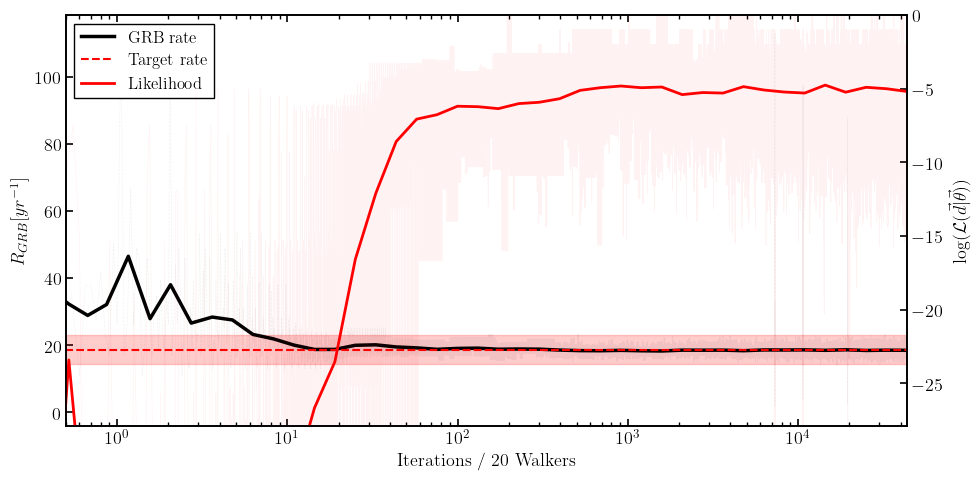

In [26]:
plotter.plot_convergence(n_counts=default_params.yearly_rate)

The `plot_autocorrelation_times` function shows a good estimate to check if the MCMC has converged, calculating the number of steps it takes for the chain to forget its initial conditions. As a rule of thumb if that number is $\tau < N/50$ the chain has converged.

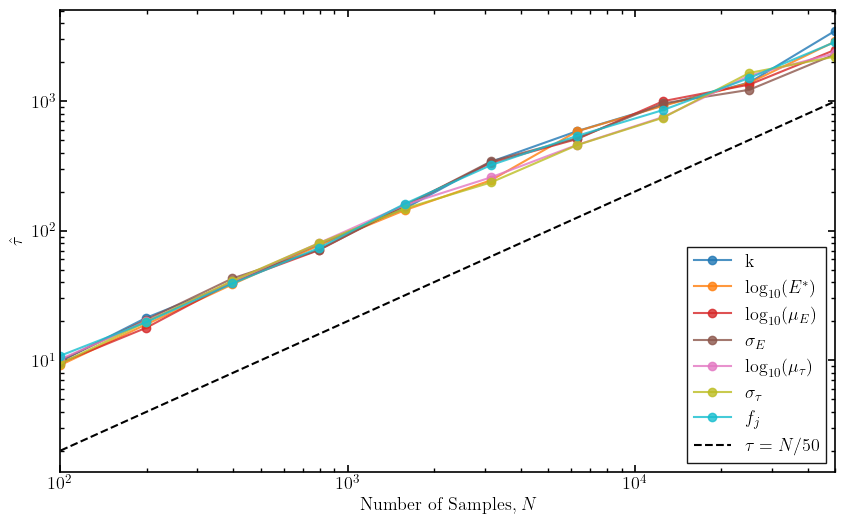

In [27]:
plotter.plot_autocorrelation_times()

Corner plots allow you to see the distribution of the parameters and the correlation between them. The `create_corner_comparison` function is used to plot the corner plots, and can be used to compare different chains.

The `truths` variable plots the medians you would expect your MCMC to converge to, and in particular `padding percentage` is mainly relevant when taking into account multiple chains.

<div class="alert alert-info" role="alert">
  <strong>Tip:</strong> Multiple chains can be compared by adding multiple chains / names in an array.
</div>

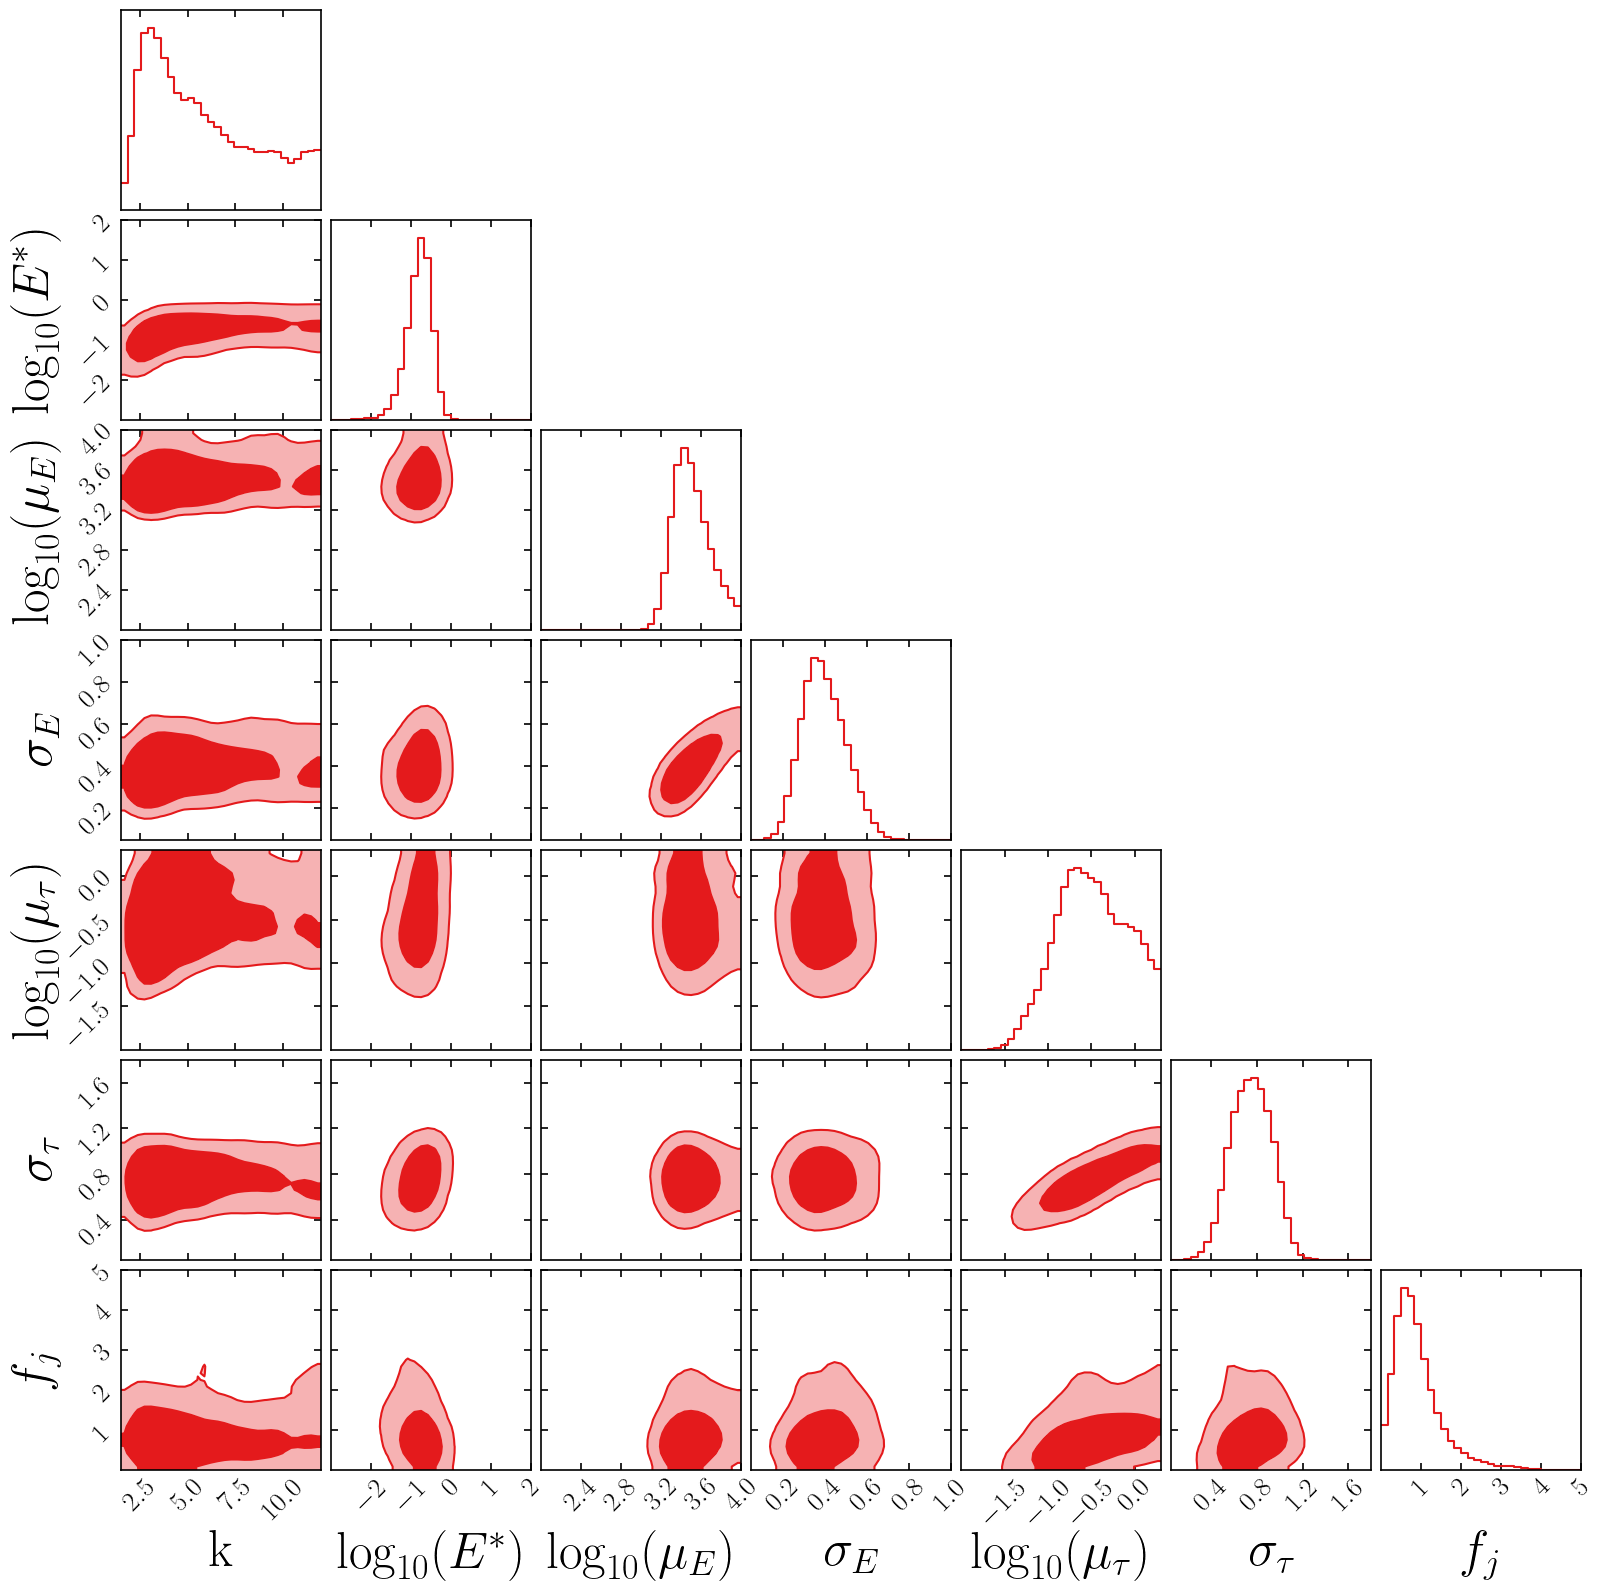

In [31]:
fig = plotter.create_corner_plot(filename="corner_plot_fiducial_newest_bests_good_old_fj10")

Another helper function can then be used to quickly show the median and the 90% confidence interval of the parameters. As mentioned here multiple chains can be used to compare the results. The table is also given as output if you wish to use it in a latex document.

In [29]:
table = plotter.show_parameter_table()

AttributeError: 'MCMCPlotter' object has no attribute 'LATEX_LABELS'

## Pretty plots for checking convergence

### Auto correlation and Exploration

For the `plot_autocorrelation` function you can study the autocorrelation of each sample, you would expect this to go to 0 if the MCMC has converged. 

The `plot_exploration` function shows you quantitatively how well the MCMC is exploring the parameter space. You want a **fuzzy-caterpillar** shape, if the shape is more like a **worm** the MCMC is not exploring the parameter space well.

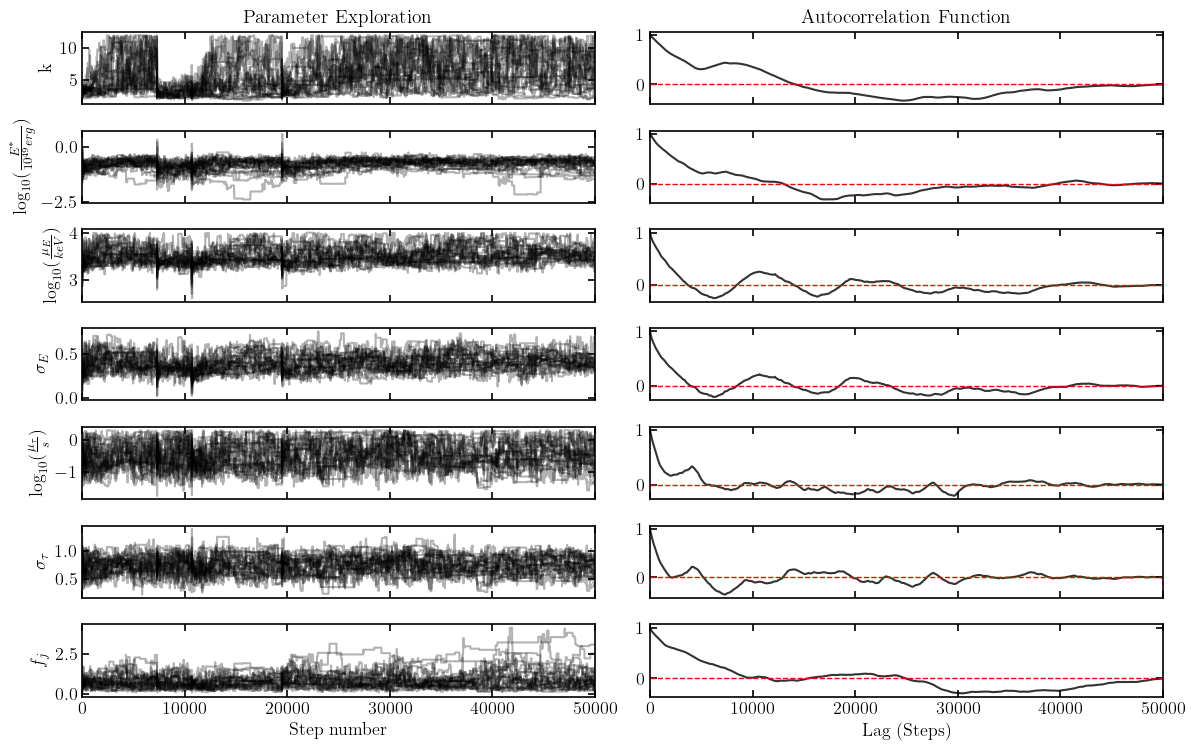

In [ ]:
plotter.plot_diagnostics()

### Likelihood Evolution
You can also study the single likelihood terms as they evolve over the MCMC run with `plot_probabilities`.

### Posterior Predicitve Checks

These checks are more rigorous as they directly compare the data / model you are using to generated samples. The `extract_samples_and_calculate_cdfs` generates observables that you can study, and `plot_cdf_comparison_single` compares the empirical and simulated Cumulative Distributions.

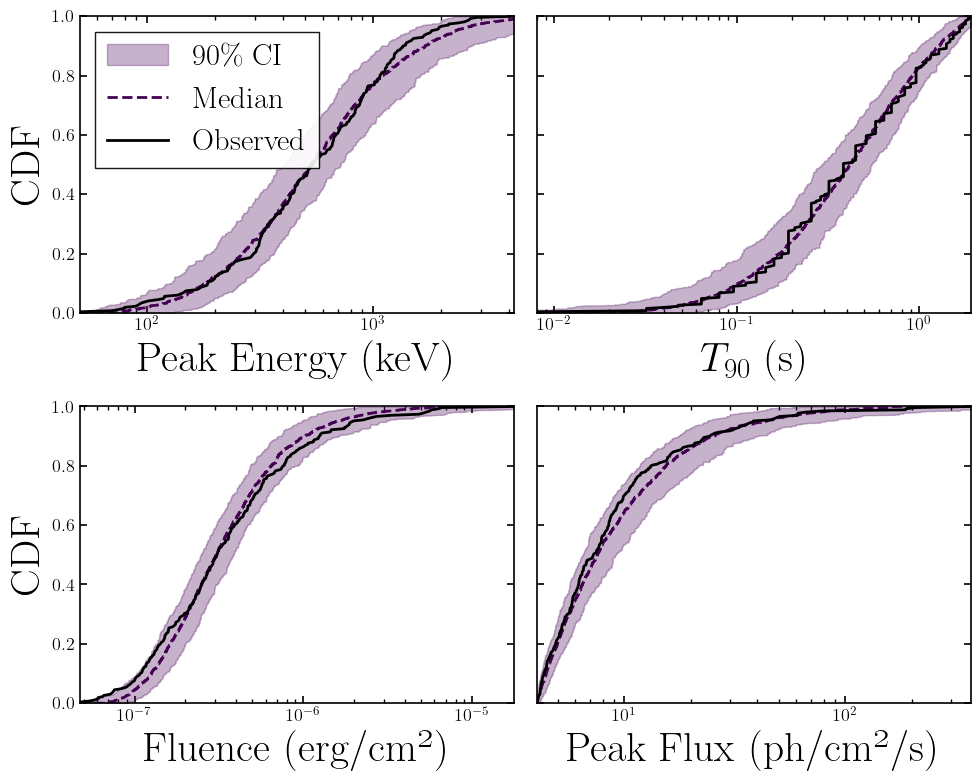

(<Figure size 1000x800 with 4 Axes>,
 array([[<Axes: xlabel='Peak Energy (keV)', ylabel='CDF'>,
         <Axes: xlabel='$T_{90}$ (s)'>],
        [<Axes: xlabel='Fluence (erg/cm²)', ylabel='CDF'>,
         <Axes: xlabel='Peak Flux (ph/cm²/s)'>]], dtype=object))

In [ ]:
dict_data = posteriors.extract_samples_and_calculate_cdfs(backend, 
                                                          default_params, 
                                                          default_interpolator, 
                                                          discard   =   DISCARD, 
                                                          flatten   =   False, 
                                                          choices   =   150)
plots_oop.plot_cdf_comparison(data_dict, [dict_data], output_dir = output_dir)

Output_files/Testing_years/alternative_fiducial_newest_bests_good_old_fj10


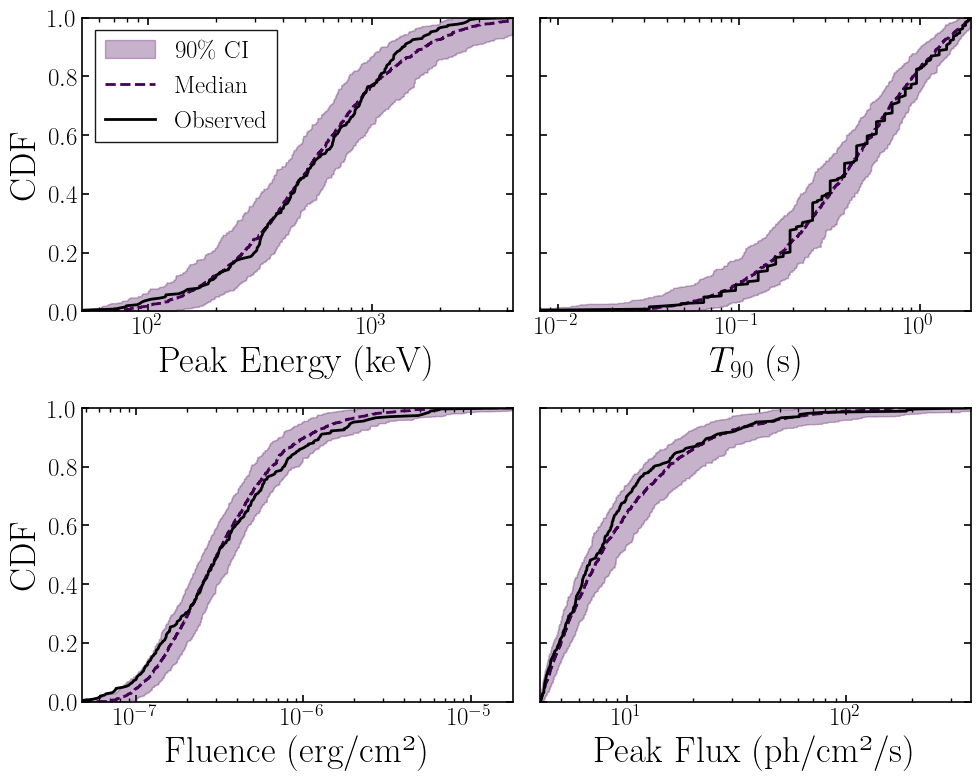

(<Figure size 1000x800 with 4 Axes>,
 array([[<Axes: xlabel='Peak Energy (keV)', ylabel='CDF'>,
         <Axes: xlabel='$T_{90}$ (s)'>],
        [<Axes: xlabel='Fluence (erg/cm²)', ylabel='CDF'>,
         <Axes: xlabel='Peak Flux (ph/cm²/s)'>]], dtype=object))

In [ ]:
plots_oop.plot_cdf_comparison(data_dict, [dict_data], output_dir = output_dir)

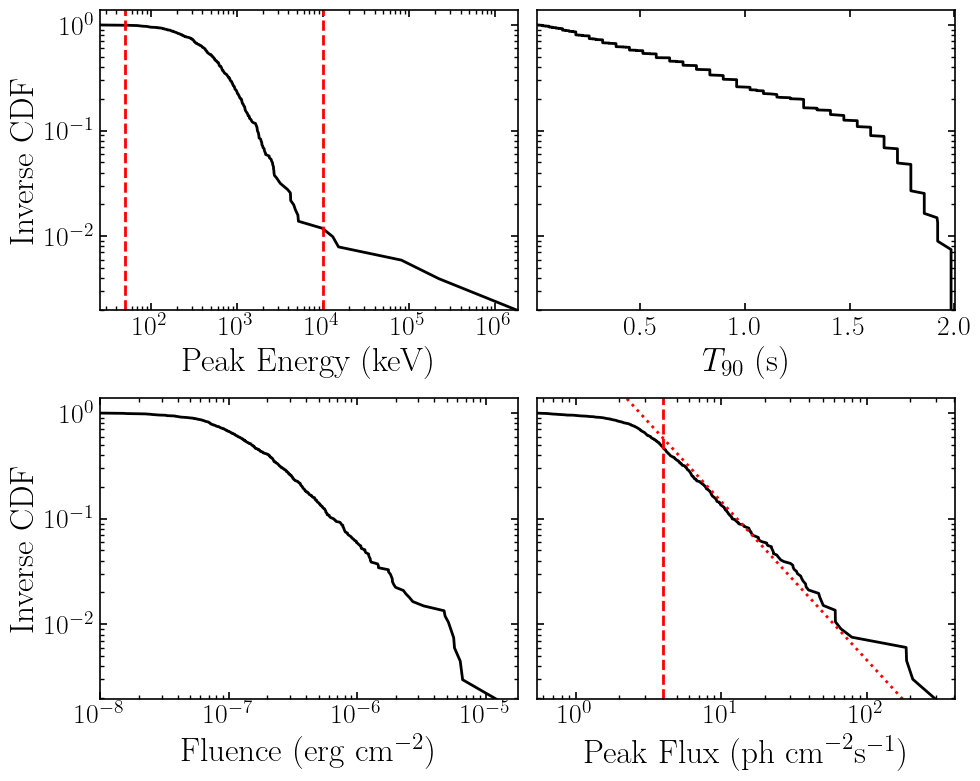

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

catalogue_data = datafiles / "burst_catalog.dat"
catalogue_data = pd.read_csv(catalogue_data)

# Define cuts
flux_cut = 4
t90_cut = 2
energy_lower_cut = 50
energy_upper_cut = 10000

# Extract data and remove NaN values
pflux   = catalogue_data["FLUX_BATSE_64"].dropna()
pflux   = pflux[pflux > 0.5]  # Apply flux cut
t90     = catalogue_data["T90"].dropna()
fluence = catalogue_data["FLUENCE_BATSE"].dropna()
epeak   = catalogue_data["PFLX_COMP_EPEAK"].dropna()
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharey='row')
fontsize_label = 24
fontsize_ticks = 20

# Plot 1: Flux
ax1 = axes[0, 0]
epeak_sorted = np.sort(epeak)
#remove 0s
epeak_sorted = epeak_sorted[epeak_sorted > 0]  # Remove zero values
n_epeak = np.arange(len(epeak_sorted), 0, -1) / len(epeak_sorted)  # Normalize
ax1.loglog(epeak_sorted, n_epeak, 'k', linewidth=2)
ax1.axvline(energy_lower_cut, color='red', linestyle='--', linewidth=2, label=f'Lower cut: {energy_lower_cut}')
ax1.axvline(energy_upper_cut, color='red', linestyle='--', linewidth=2, label=f'Upper cut: {energy_upper_cut}')
ax1.set_xlabel('Peak Energy (keV)', fontsize=fontsize_label)
ax1.set_ylabel('Inverse CDF', fontsize=fontsize_label)
# Set tick sizes using tick_params for reliability
ax1.tick_params(axis='both', which='major', labelsize=fontsize_ticks)
ax1.set_xlim(min(epeak_sorted), max(epeak_sorted))

# Plot 2: T90
ax2 = axes[0, 1]
t90_sorted = np.sort(t90)
t90_sorted = t90_sorted[t90_sorted > 0]
n_t90 = np.arange(len(t90_sorted), 0, -1) / len(t90_sorted)  # Normalize
ax2.loglog(t90_sorted, n_t90, 'k', linewidth=2)
ax2.set_xscale('linear')
ax2.set_xlabel('$T_{90}$ (s)', fontsize=fontsize_label)
ax2.tick_params(axis='both', which='major', labelsize=fontsize_ticks)
ax2.set_xlim(min(t90_sorted), 1.01*max(t90_sorted))
ax1.set_ylim(min(n_epeak), None)

# Plot 3: Fluence
ax3 = axes[1, 0]
fluence_sorted = np.sort(fluence)
fluence_sorted = fluence_sorted[fluence_sorted > 0]  # Remove zero values
n_fluence = np.arange(len(fluence_sorted), 0, -1) / len(fluence_sorted)  # Normalize
ax3.loglog(fluence_sorted, n_fluence, 'k', linewidth=2)
ax3.set_xlim(min(fluence_sorted), max(fluence_sorted))
ax3.set_xlabel(r'Fluence $(\text{erg cm}^{-2})$', fontsize=fontsize_label)
ax3.set_ylabel('Inverse CDF', fontsize=fontsize_label)
ax3.tick_params(axis='both', which='major', labelsize=fontsize_ticks)
ax3.set_ylim(min(n_epeak), None)

# Plot 4: Peak Energy
ax4 = axes[1, 1]
flux_sorted = np.sort(pflux)
n_flux = np.arange(len(flux_sorted), 0, -1) / len(flux_sorted)  # Normalize

# fit the pflux with a log-log line above the flux_cut
flux_mask           = (flux_sorted > flux_cut+1) & (flux_sorted < 50)  # Apply flux cut
flux_sorted_cut     = flux_sorted[flux_mask]
n_flux_cut          = n_flux[flux_mask]

# Fix slope to -3/2 and fit only the intercept
fixed_slope = -3/2
log_flux = np.log10(flux_sorted_cut)
log_n_flux = np.log10(n_flux_cut)
intercept = np.mean(log_n_flux - fixed_slope * log_flux)
ax4.loglog(flux_sorted, n_flux, 'k', linewidth=2)
ax4.plot(flux_sorted, 10**(intercept * 1.03 + fixed_slope * np.log10(flux_sorted)), 'r:', linewidth=2, label=f'Power Law (slope = {fixed_slope})')
ax4.axvline(flux_cut, color='red', linestyle='--', linewidth=2, label=f'Cut at {flux_cut}')
ax4.set_xlabel(r'Peak Flux $(\text{ph cm}^{-2} \text{s}^{-1})$', fontsize=fontsize_label)
ax4.tick_params(axis='both', which='major', labelsize=fontsize_ticks)
ax4.set_xlim(min(flux_sorted), 1.1*max(flux_sorted))

plt.tight_layout()
plt.savefig('observed_cdfs.pdf', dpi=600)

 # Grinta

Fitted power law: a = -0.4948365989358463, b = -0.49999999999999833


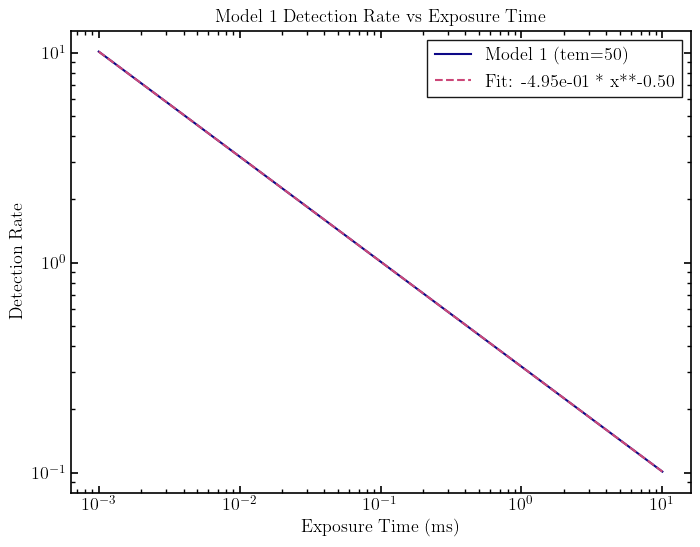

In [ ]:
import pandas as pd
# load data_phscm2.csv, time, models1, models2, models3, models4, models5, extract time vs models1 not the extact name

data = pd.read_csv('data_phscm2.csv')
exposure_time = data['Time (ms)']
model1 = data['Model 1 (tem=50)']

plt.loglog(exposure_time, model1, label='Model 1 (tem=50)')

# power law fit to model1
from scipy.optimize import curve_fit
def power_law(x, a, b):
    return 10**a * x**b

params, covariance = curve_fit(power_law, exposure_time, model1)
a_fit, b_fit = params
print(f"Fitted power law: a = {a_fit}, b = {b_fit}")
plt.loglog(exposure_time, power_law(exposure_time, a_fit, b_fit), label=f'Fit: {a_fit:.2e} * x**{b_fit:.2f}', linestyle='--')
plt.xlabel('Exposure Time (ms)')
plt.ylabel('Detection Rate')
plt.title('Model 1 Detection Rate vs Exposure Time')
plt.legend()

In [ ]:
%load_ext autoreload
%autoreload 2

import src.predictions as predictions

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# make_observations_w_sensitivity(thetas, params : SimParams, interps : Interps, 
#                       ):
years       = 100
thetas_best = backend.get_chain(discard=DISCARD, flat=True)[np.argmax(backend.get_log_prob(discard=DISCARD, flat=True))]
obs         = predictions.make_observations_w_sensitivity(thetas_best, params=default_params, interps=default_interpolator, limits=predictions.DEFAULT_LIMITS_GRINTA, n_yrs=years)

Total detected events over 100 years: 6598


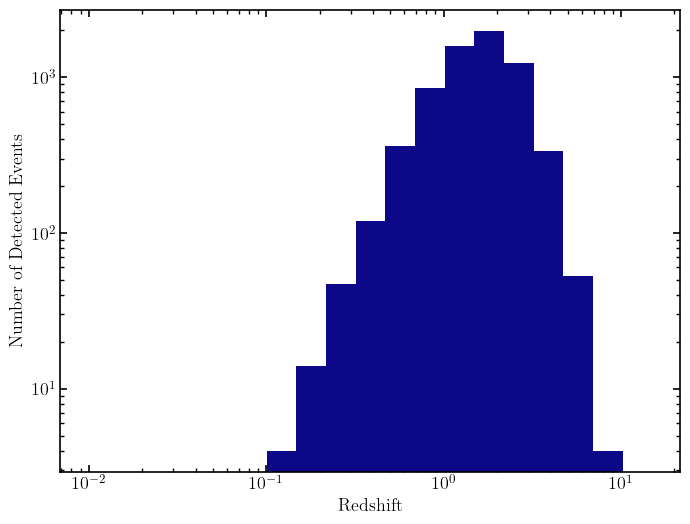

In [ ]:
redshift = obs['z_det']
print(f"Total detected events over {years} years: {len(redshift)}")
bins = np.logspace(np.log10(0.01), np.log10(15), 20)
plt.hist(redshift, bins=bins, log=True)
plt.xscale('log')
plt.xlabel('Redshift')
plt.ylabel('Number of Detected Events')
plt.show()

In [ ]:
obs.keys() # dict_keys(['t_det', 't_peak_det', 'f_det', 'Ep_det', 'Fp_phot', 'z_det', 'theta_v_det', 'triggered_events', 'isotropic_energy_det'])

t_det = obs['t_det'] 
# print detected rate 
print(f"Detected rate over {years} years: {len(t_det)/years} per year")

# export cat with z and theta_v only
import pandas as pd

short_cat = {   
    'z': obs['z_det'],
    'theta_v': obs['theta_v_det']
}

df = pd.DataFrame(short_cat)
df.to_csv('detected_catalogue_100yrs.csv', index=False)

Detected rate over 100 years: 65.98 per year


In [ ]:
1/0

ZeroDivisionError: division by zero

Using redshift model: samples_fiducial_Hrad_A1.0_BNSs_0.dat with 359079 BNSs.
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
Best samples are used for PPC: [ 0.35872655 -1.08764452  3.49666707  0.37822731 -1.23599069  0.50051259
  0.38882127]


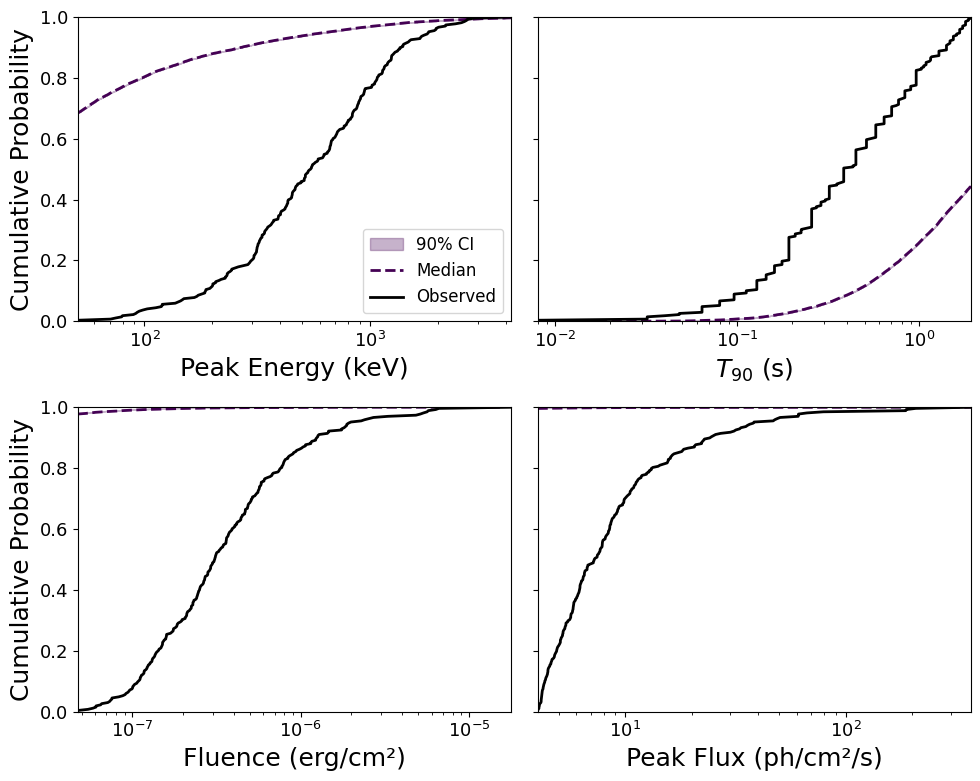

(<Figure size 1000x800 with 4 Axes>,
 array([<Axes: xlabel='Peak Energy (keV)', ylabel='Cumulative Probability'>,
        <Axes: xlabel='$T_{90}$ (s)'>,
        <Axes: xlabel='Fluence (erg/cm²)', ylabel='Cumulative Probability'>,
        <Axes: xlabel='Peak Flux (ph/cm²/s)'>], dtype=object))

In [ ]:
NEW_L = {
    "F_LIM"         : 0,         # 4 ph/cm^2/s in 64 ms
    "T90_LIM"       : 200,         # 1 s
    "EP_LIM_UPPER"  : 10_000,    # 10_000 keV
    "EP_LIM_LOWER"  : 5,        # 50 keV
}

params_all = {
    "alpha"         : -0.67,    # 2/3 from synchrotron
    "beta_s"        : -2.59,    # Average value from GRBs
    "n"             : 2,        # Smoothly broken power law curvature
    "theta_c"       : 3.4,      # Ghirlanda half-angle of jet core (from GW170817)
    "theta_v_max"   : 20,       # Maximum viewing angle of the jet (in degrees)
    "z_model"       : 'fiducial_Hrad_A1.0'    #? Optional, model to use for redshift distribution
}

default_params_all, default_interpolator_all, data_dict = init.initialize_simulation(datafiles, params_all, size_test = 10000) #? Catalogue data from fermi GBM# GRB Jet structure assumptions

dict_data = posteriors.extract_samples_and_calculate_cdfs(backend, 
                                                          default_params_all, 
                                                          default_interpolator_all, 
                                                          discard   =   3_000, 
                                                          flatten   =   False, 
                                                          choices   =   10, 
                                                          limits    = NEW_L,
                                                          use_best  = True)
plots_oop.plot_cdf_comparison(data_dict, [dict_data], output_dir = output_dir)

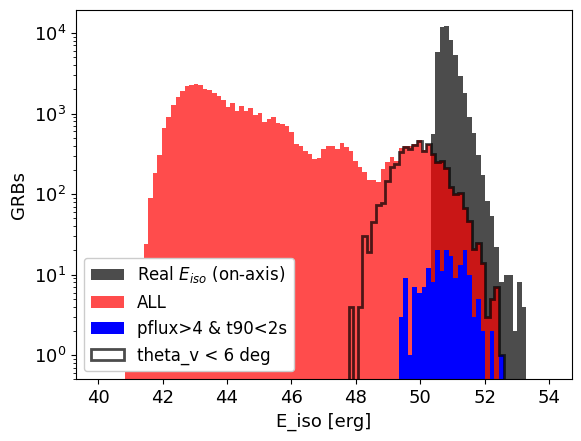

In [ ]:
# array dict_data["total_energy_det"] is list of arrays, get flat
E_iso_source    = np.concatenate(dict_data["isotropic_energy_det"])
E_iso_10_       = np.log10(E_iso_source)

#take pflux, and t90 plot only those
pflux_source   = np.concatenate(dict_data["pflux"])
t90_source     = np.concatenate(dict_data["t90"])
cuts = (pflux_source >= 4) & (t90_source <= 2) 
E_iso_10_GBM = E_iso_10_[cuts]

# show detected angles
theta_det_source    = np.concatenate(dict_data["theta_det"])
theta_rad      = np.rad2deg(theta_det_source)
# only plot those with theta_det < 10 deg
E_iso_10_angle = E_iso_10_[theta_rad <= 6]

#total_energy_det
E_iso_real  = np.concatenate(dict_data["total_energy_det"])
E_iso_10 = np.log10(E_iso_real)

#Get the peak of the real E_iso distribution, then everything bellow it make a mask 
E_iso_real_counts, E_iso_real_bins = np.histogram(np.log10(E_iso_real), bins=np.linspace(40, 54, 100))
peak_index = np.argmax(E_iso_real_counts)
peak_value = E_iso_real_bins[peak_index]

#plt.hist(E_iso_10, density=True, bins=np.linspace(48, 54, 50), histtype='step', color='k', linewidth=2, alpha=0.7, label="Samuele")
plt.hist(E_iso_10, bins=np.linspace(40, 54, 100), color='black', linewidth=2, alpha=0.7, label="Real $E_{iso}$ (on-axis)", log=True)
plt.hist(E_iso_10_, bins=np.linspace(40, 54, 100), color='red', linewidth=2, alpha=0.7, label="ALL", log=True)
plt.hist(E_iso_10_GBM, bins=np.linspace(40, 54, 100), color='blue', linewidth=2, label="pflux>4 & t90<2s", log=True)
plt.hist(E_iso_10_angle, bins=np.linspace(40, 54, 100), histtype='step', color='k', linewidth=2, alpha=0.7, label="theta_v < 6 deg", log=True)
plt.xlabel("E_iso [erg]")
plt.ylabel("GRBs")
plt.ylim(0.5, None)
#make legend not transparent and square
plt.legend(framealpha=1, fontsize=12, loc='lower left')
plt.show()


--- 1. Running General Population Analysis (Structured) ---
Generating Combined Analysis Plot...
Saving plot to Output_files/Unified_Plots/combined_population_analysis


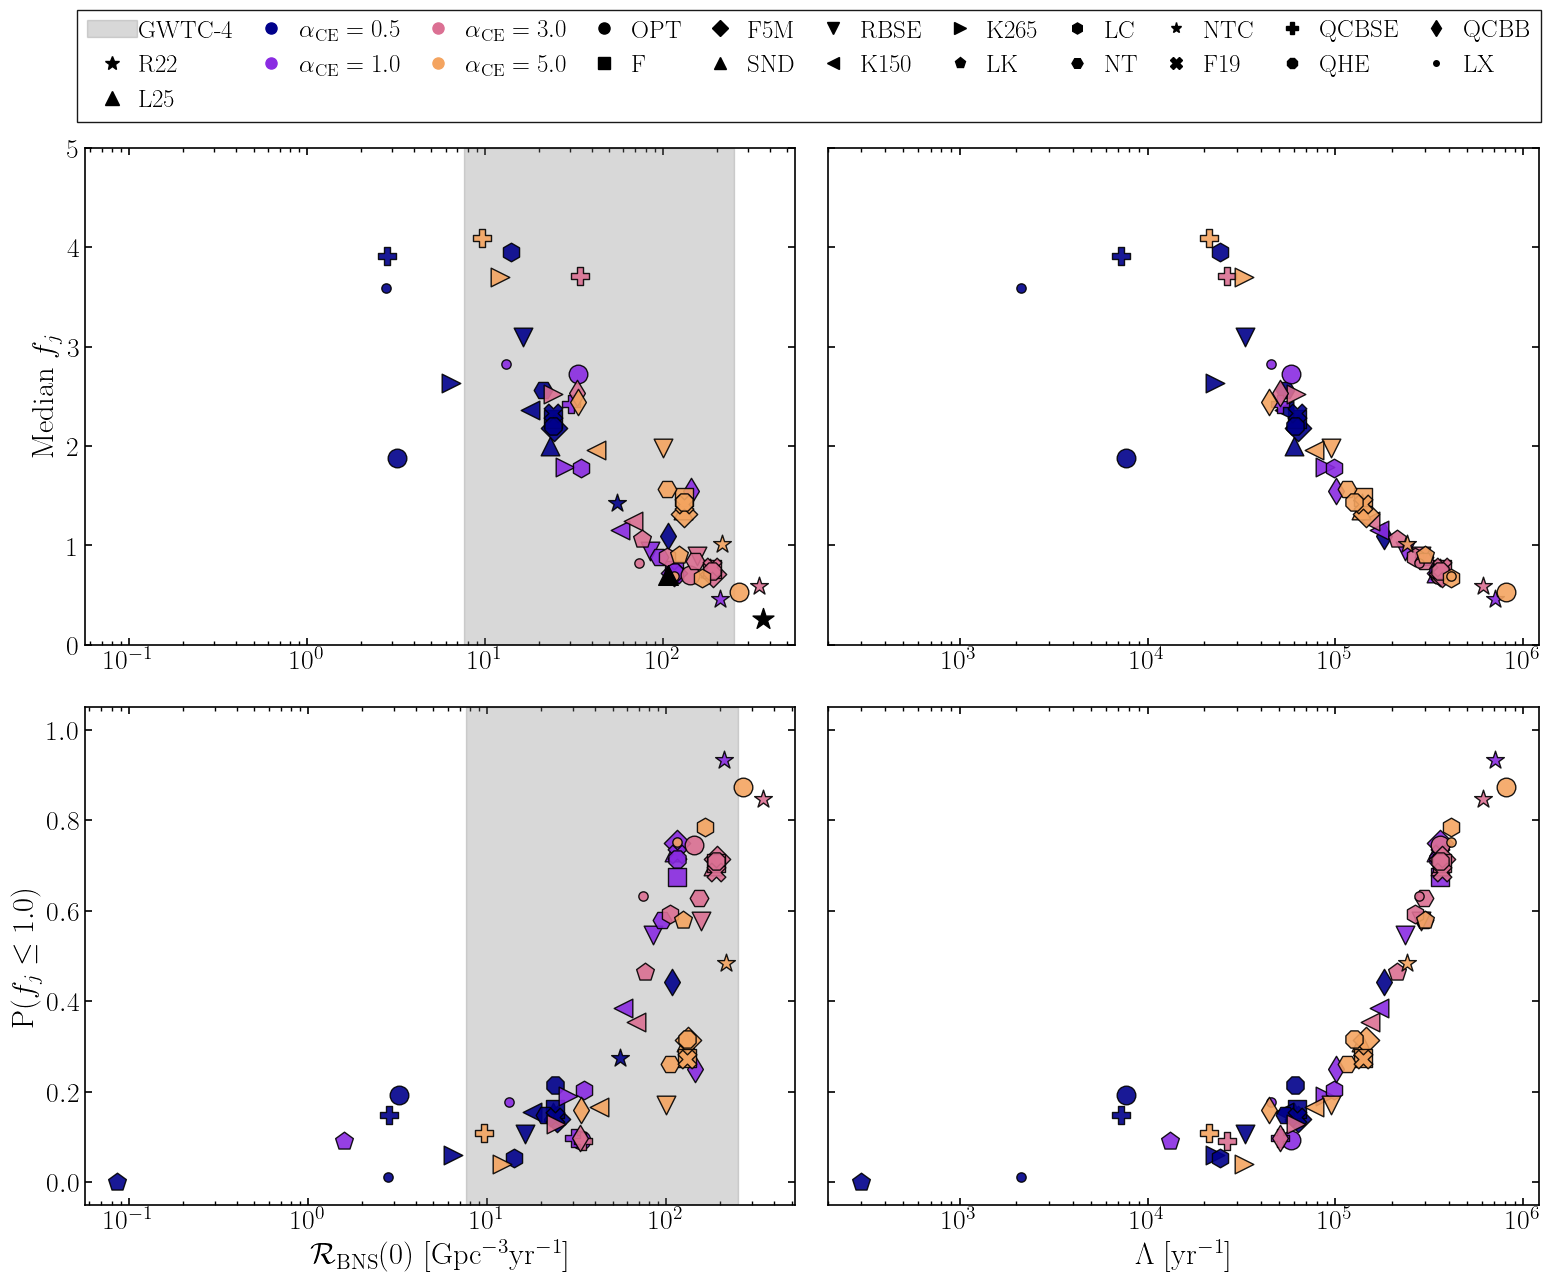

Generating Violin Plots...
Saving plot to Output_files/Unified_Plots/fj_violin_plot_structured


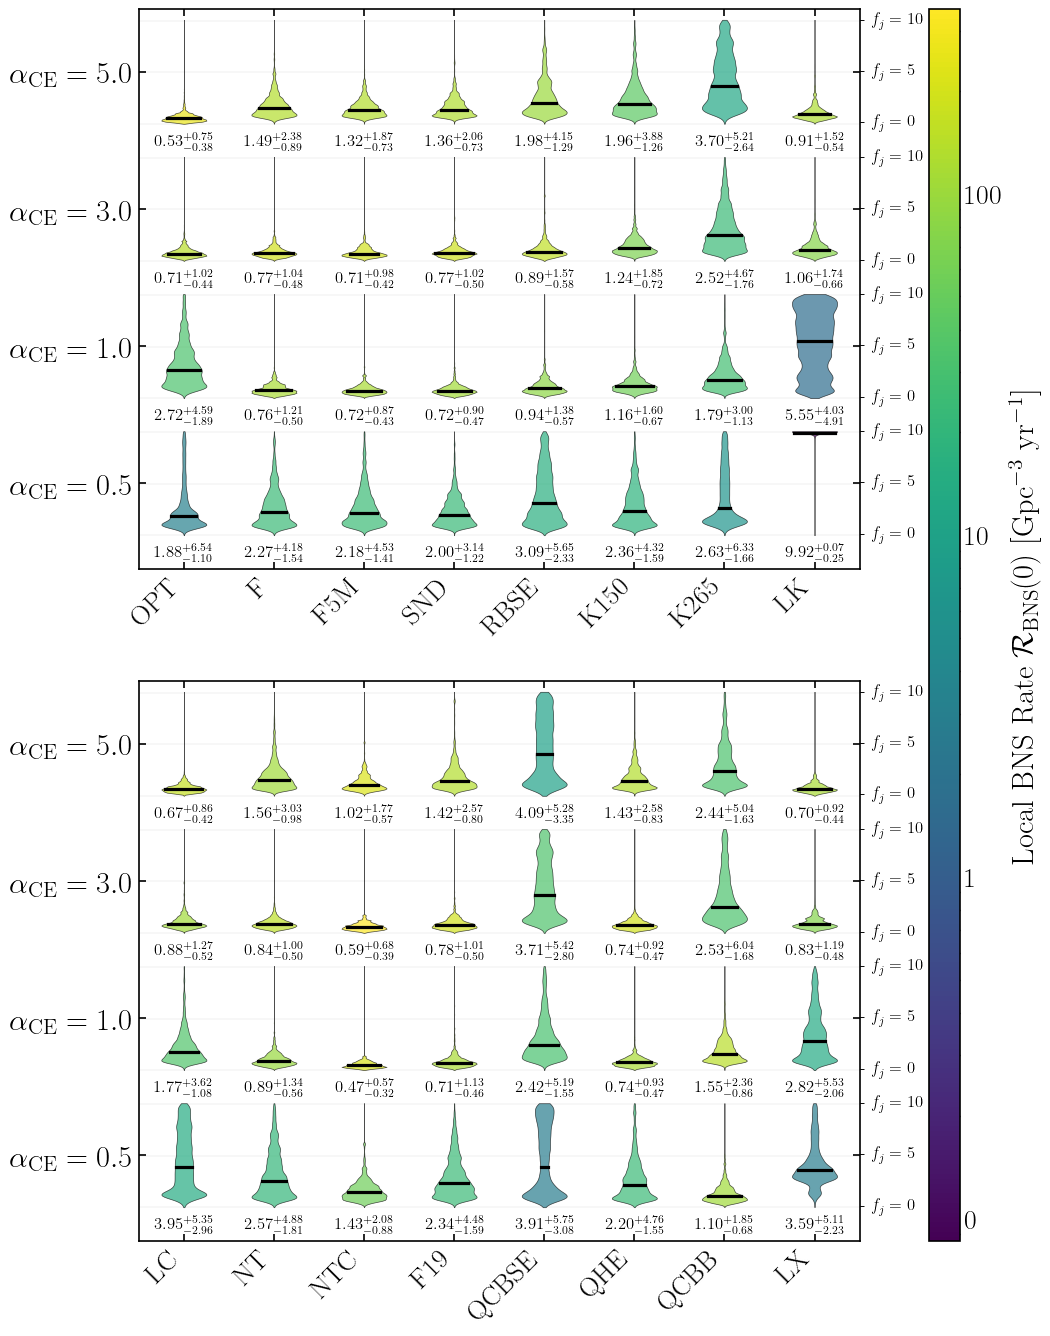

Generating sGRB Rate Posteriors...
Saving plot to Output_files/Unified_Plots/sgrb_rate_posteriors_structured


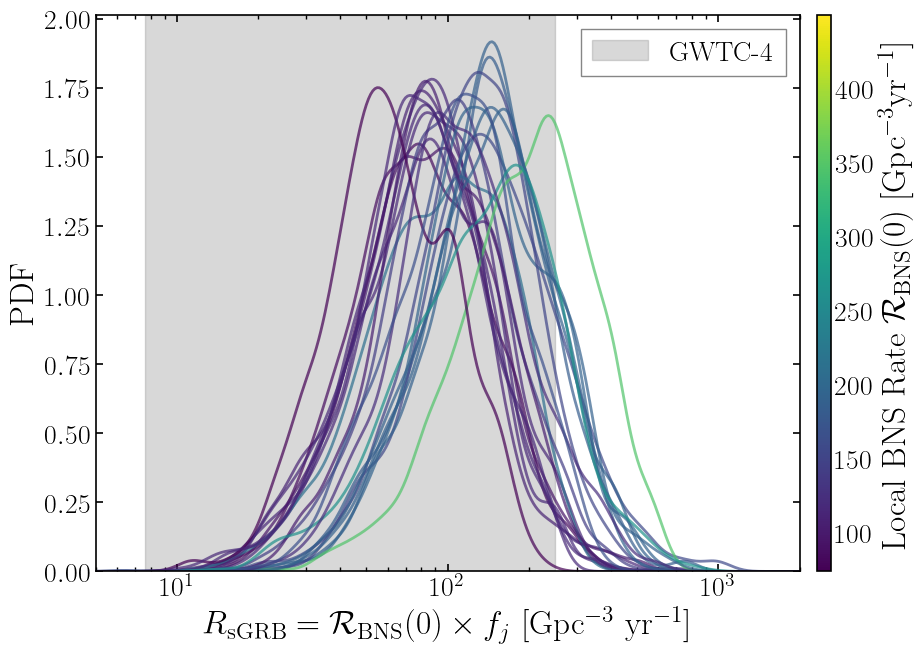


--- 2. Running Fj Posterior Comparison (Fiducial: fiducial_Hrad_A1.0) ---
Saved Output_files/Unified_Plots/fj_posteriors_comparison.pdf


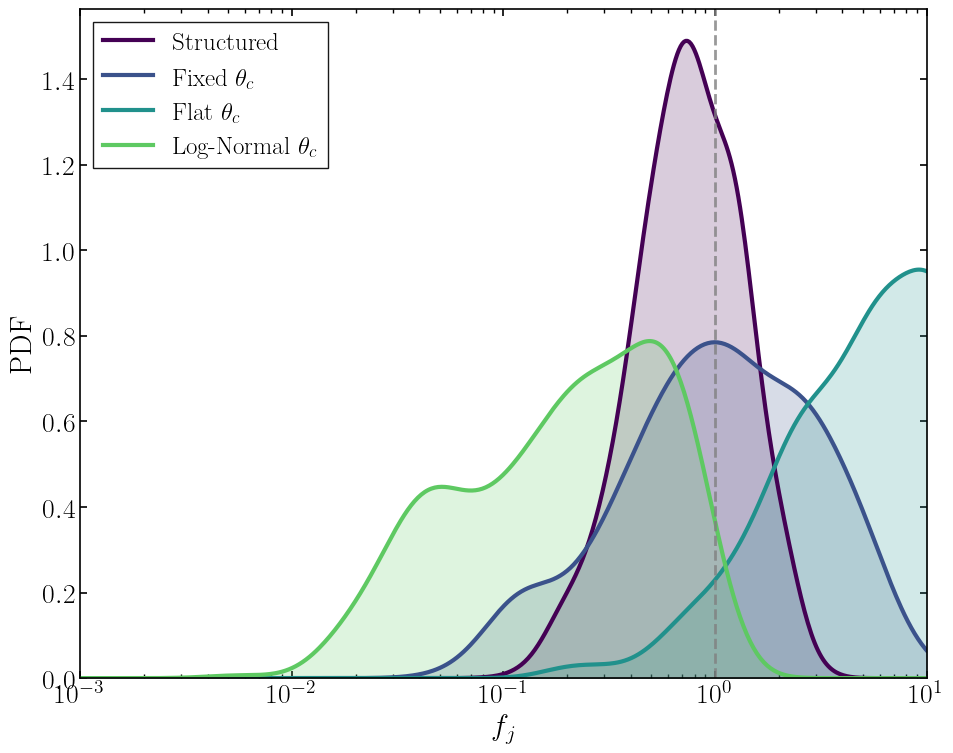

In [40]:
from src.unified_plotter import *
run_general_analysis()

# 2. Run Single Model Posterior Comparison
run_posterior_comparison(fiducial_name="fiducial_Hrad_A1.0")


--- 3. Running Theta Star 2x2 Grid Analysis ---
Initializing Fixed Theta_c Plotter...
Loading and processing model data...
Successfully processed 64 models.
Initializing Flat Theta Plotter...
Loading and processing model data...
Successfully processed 64 models.
Initializing Log-Normal Plotter...
Loading and processing model data...
Successfully processed 64 models.
16 16
16 16
16 16
16 16
No valid samples found within boundary limit.
Could not compute theta* for model fiducial_HGoptimistic_A0.5 with local rate 3.22
No valid samples found within boundary limit.
Could not compute theta* for model fiducial_kick265_A0.5 with local rate 6.4
No valid samples found within boundary limit.
Could not compute theta* for model fiducial_klencki_A0.5 with local rate 0.0856
No valid samples found within boundary limit.
Could not compute theta* for model fiducial_l01_A0.5 with local rate 14.0
No valid samples found within boundary limit.
Could not compute theta* for model fiducial_qcbse_A0.5 with lo

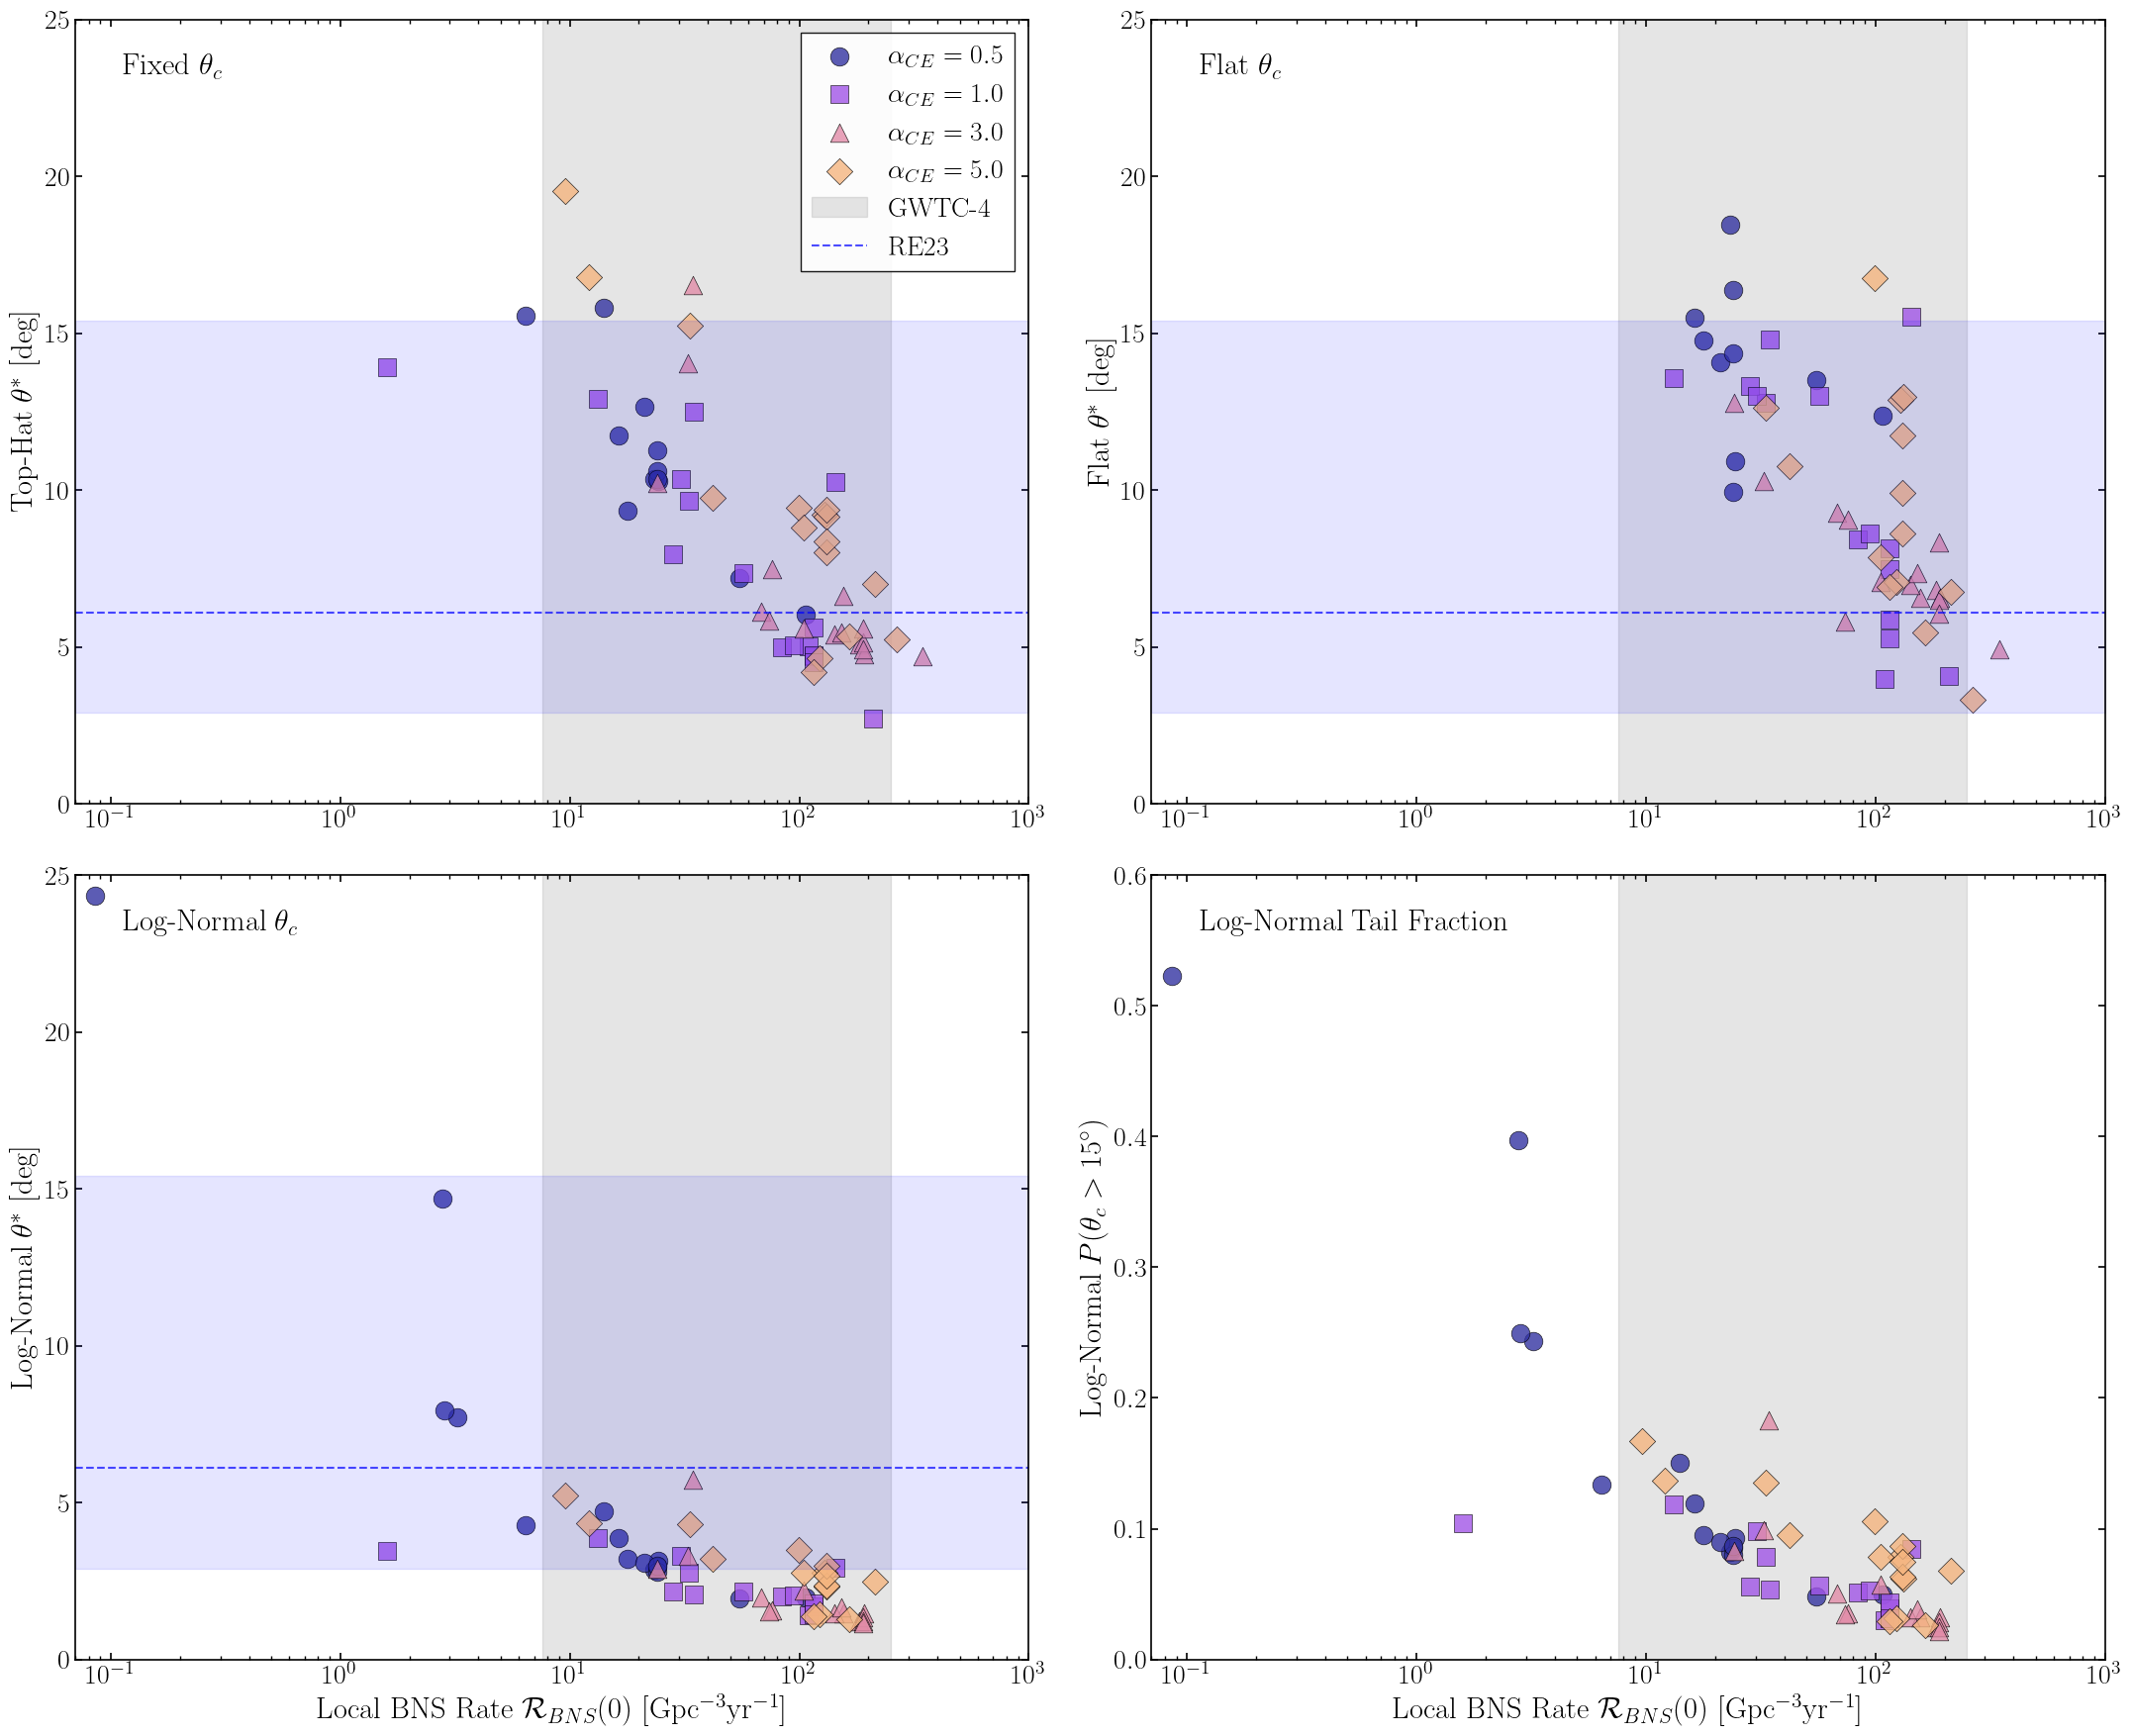

Generating Individual Helper Plots...
Saved plot to Output_files/Unified_Plots/violins_fj_fixed_angles.pdf


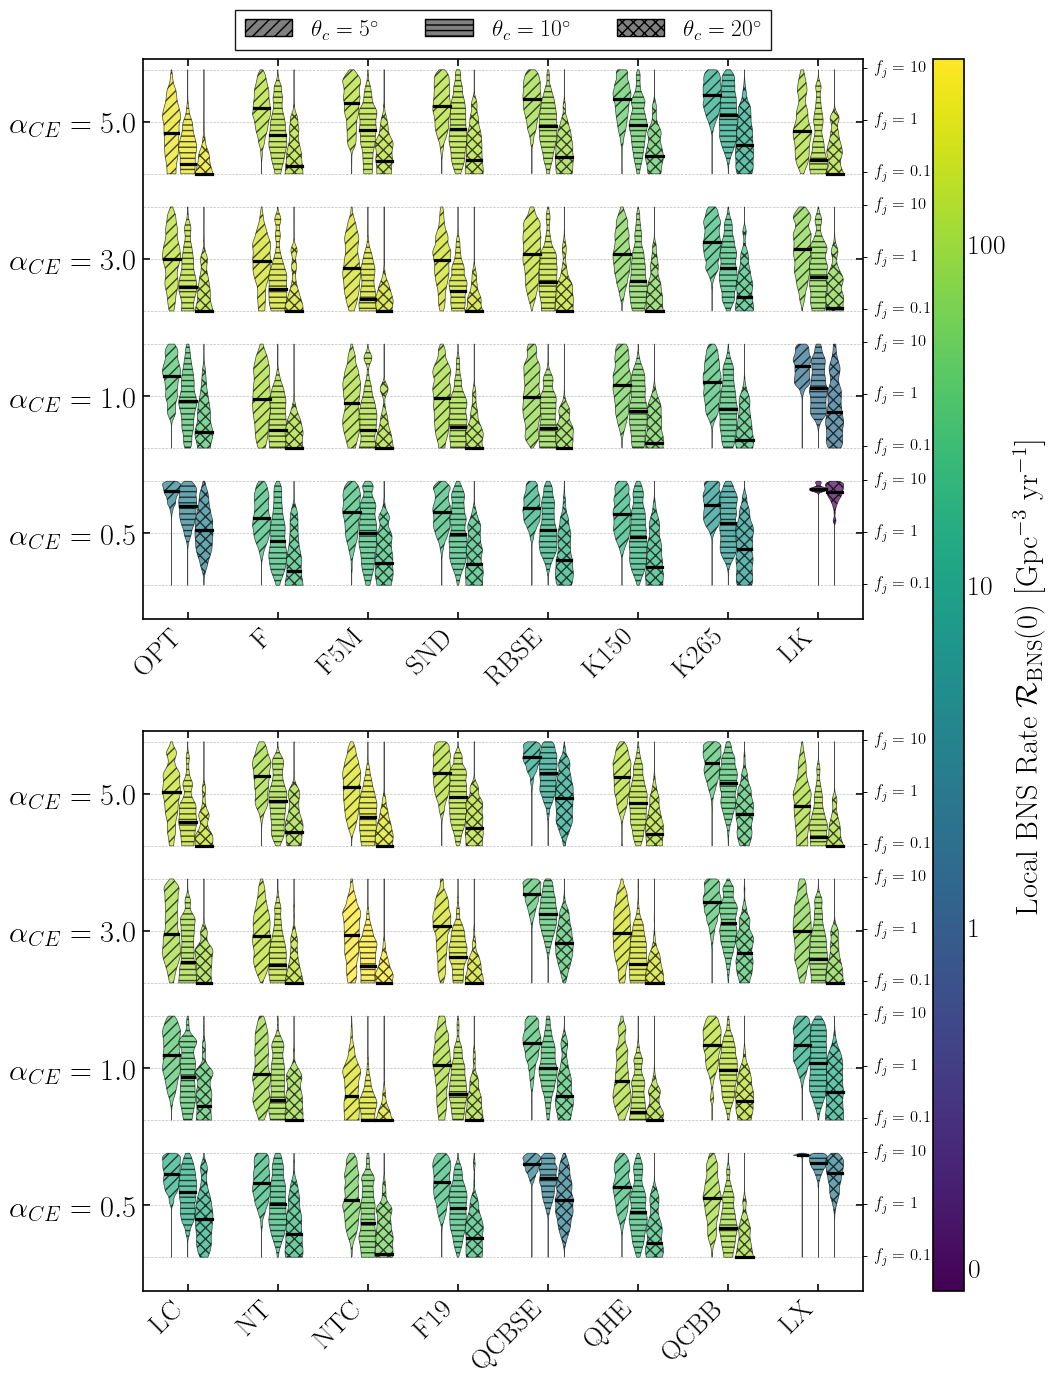

Saved plot to Output_files/Unified_Plots/violins_epsilon.pdf


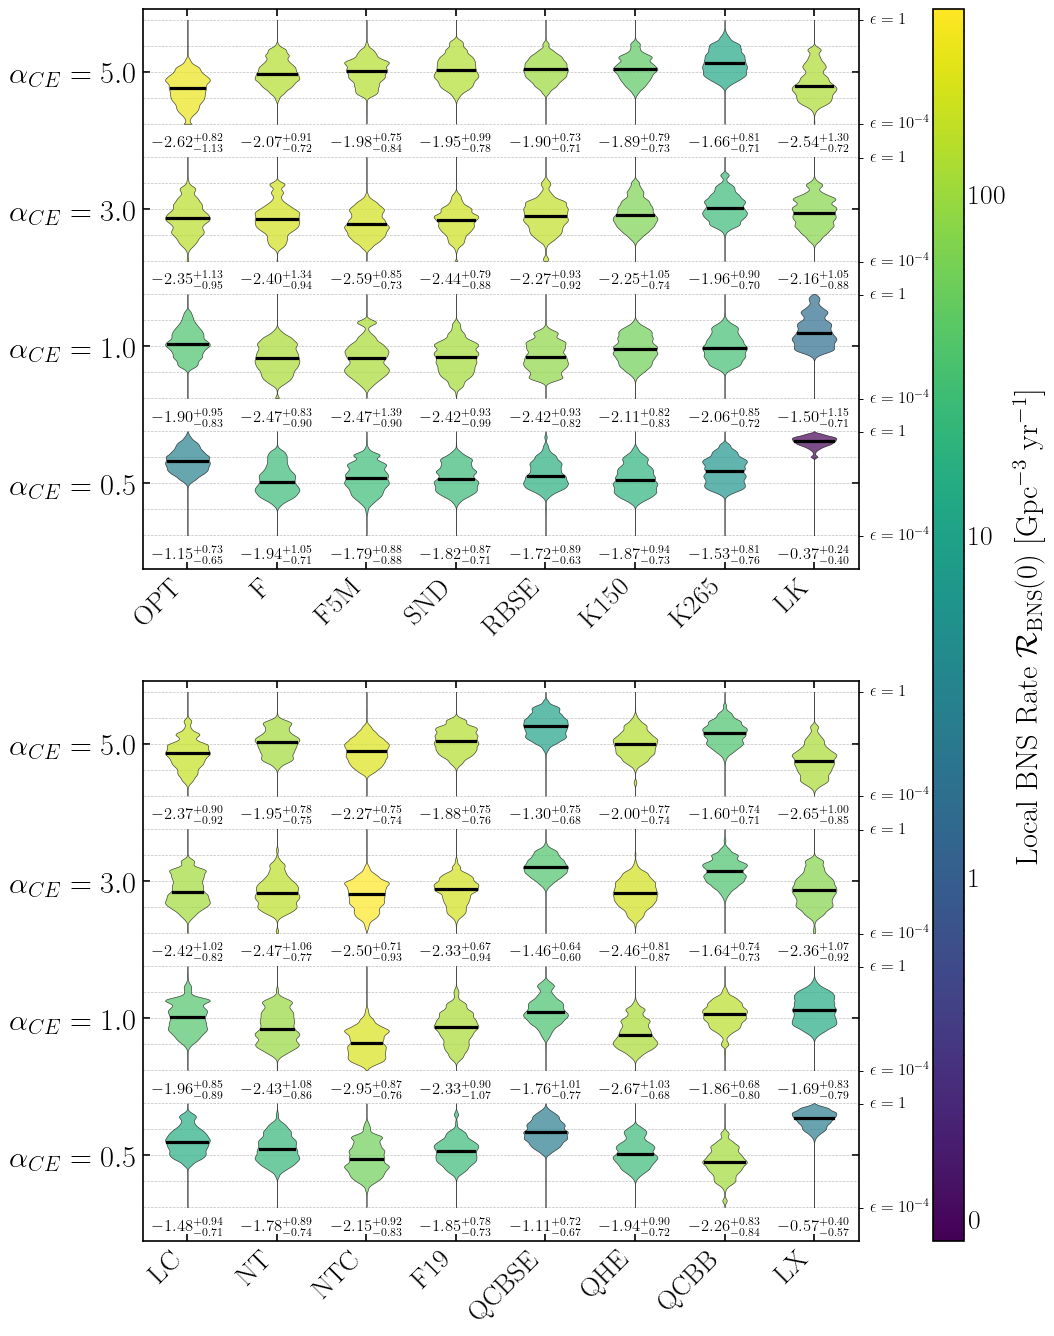

Saved plot to Output_files/Unified_Plots/fj_fraction_vs_rate_thetac.pdf


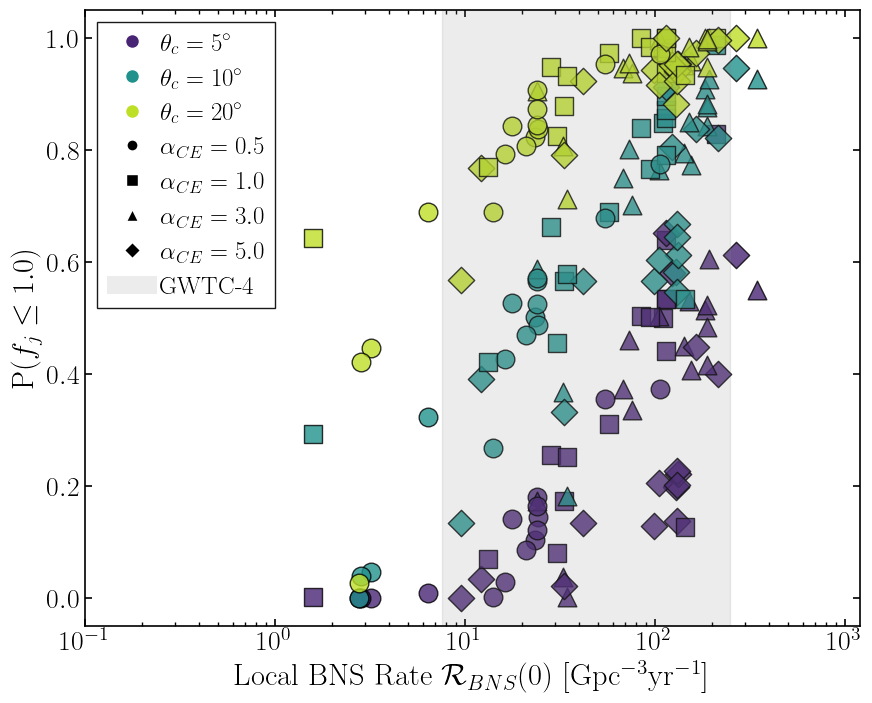

In [41]:
# 3. Run the Complex 2x2 Grid and Special plots
run_theta_star_grid_analysis()

In [ ]:
# run src/unified_plotter.py
!

Traceback (most recent call last):
  File "/mnt/c/Users/Ludovico/Desktop/gwpop_LudoDe/src/unified_plotter.py", line 8, in <module>
    from .pop_plot import PopulationAnalysis
ImportError: attempted relative import with no known parent package
